In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

In [3]:
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import fix_orbital_order

/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
orbitals = {'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]}}

In [6]:
# root = 'examples/data/periodic/graphene_supercell_variety'
# ORBS = 'sto-3g'
# graphene = read(f'{root}/graphene_variety.xyz', '1')
# graphene.pbc = True

# kmesh = [8,8,1]
# kfock = np.load(f"{root}/fock_hex_881.npy")
# kover = np.load(f"{root}/over_hex_881.npy")
# kfock = [kfock]
# kover = [kover]

# # kmesh = [[8,8,1], [12,12,1]]
# # # kmesh = [12,12,1]
# # # kfock_12121 = np.load(f"{root}/fock_hex_12121.npy")
# # kfock_12121 = np.load(f"{root}/fock_121212.npy")
# # # kover_12121 = np.load(f"{root}/over_hex_12121.npy")
# # kover_12121 = np.load(f"{root}/over_121212.npy")
# # # kfock = [kfock_12121]
# # # kover =  [kover_12121]
# # kfock = [kfock, kfock_12121]
# # kover = [kover, kover_12121]

# for ifr in range(len(kfock)):
#     for ik, (k,o) in enumerate(zip(kfock[ifr], kover[ifr])):
#         kfock[ifr][ik] = fix_orbital_order(k, graphene, orbitals[ORBS]) #### TODO <<
#         kover[ifr][ik] = fix_orbital_order(o, graphene, orbitals[ORBS])
        
# frames = [graphene]
# # frames = [graphene, graphene]

# dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = kfock, overlap_kspace = kover, device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

In [5]:
workdir = '/home/nigam/scratch/MAC/k-hamiltonian/'
root = f'{workdir}/examples/data/periodic/c2/'
ORBS = 'sto-3g'
START = 0
STOP = 20
frames = read(f'{root}/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = True

kmesh = [8,8,1]
kfock = [np.load(f"{root}/results_C2_174_881/fock_{i}_881.npy") for i in range(START, STOP)]
kover = [np.load(f"{root}/results_C2_174_881/over_{i}_881.npy") for i in range(START, STOP)]
for ifr in range(len(frames)):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
        kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = kfock, overlap_kspace = kover, device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

In [10]:
def print_matrix(matrix):
    for row in matrix:
        for v in row:
            print(f'{v:>12.6f}', end = ' ')
        print()

In [11]:
from scipy.linalg import eigvals

In [107]:
e88_G = eigvals(dataset.fock_kspace[0][0].numpy(), dataset.overlap_kspace[0][0].numpy())
e1212_G = eigvals(dataset.fock_kspace[1][0].numpy(), dataset.overlap_kspace[1][0].numpy())

e88_O = eigvals(dataset.fock_kspace[0][54].numpy(), dataset.overlap_kspace[0][54].numpy())
e1212_O = eigvals(dataset.fock_kspace[1][117].numpy(), dataset.overlap_kspace[1][117].numpy())

/home/nigam/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nigam/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


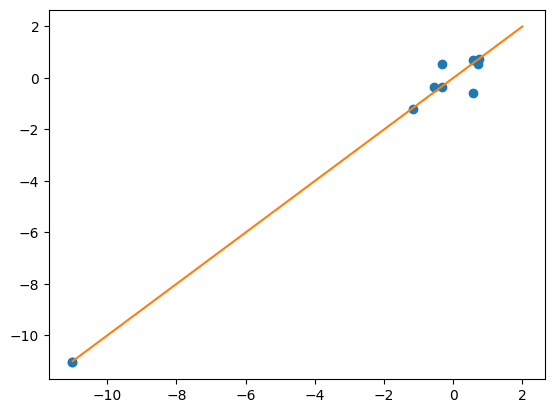

In [108]:
plt.plot(e88_G, e1212_G, 'o')
plt.plot([-11, 2], [-11, 2])

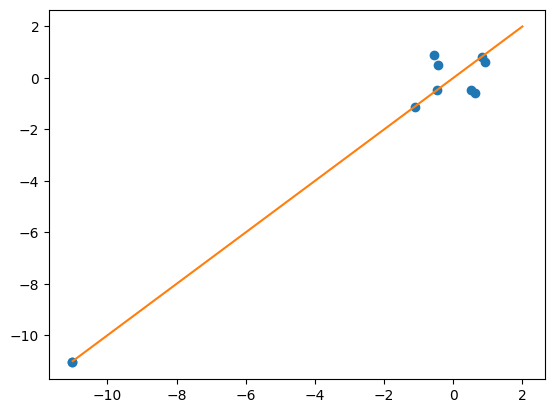

In [109]:
plt.plot(e88_O, e1212_O, 'o')
plt.plot([-11, 2], [-11, 2])

In [110]:
print_matrix(dataset.fock_kspace[0][0].numpy().real)

  -11.028024    -3.092534     0.000000    -0.000000    -0.000000    -0.000458    -1.325283     0.000000     0.000000     0.000000 
   -3.092534    -2.346847    -0.000000     0.000000    -0.000000    -1.325283    -2.188960    -0.000000     0.000000     0.000000 
    0.000000    -0.000000    -0.033483     0.000000    -0.000000    -0.000000     0.000000     0.295317    -0.000000    -0.000000 
   -0.000000     0.000000     0.000000    -0.332065     0.000000    -0.000000    -0.000000    -0.000000    -0.679034    -0.000000 
   -0.000000    -0.000000    -0.000000     0.000000    -0.033483    -0.000000    -0.000000    -0.000000    -0.000000     0.295317 
   -0.000458    -1.325283    -0.000000    -0.000000    -0.000000   -11.028024    -3.092534    -0.000000    -0.000000     0.000000 
   -1.325283    -2.188960     0.000000    -0.000000    -0.000000    -3.092534    -2.346847     0.000000    -0.000000     0.000000 
    0.000000    -0.000000     0.295317    -0.000000    -0.000000    -0.000000     0

In [111]:
print_matrix(dataset.fock_kspace[1][0].real)

  -11.046365    -3.097265    -0.000000    -0.000000     0.000057    -0.000456    -1.327277    -0.000000     0.000000     0.000009 
   -3.097265    -2.371447    -0.000000    -0.000000     0.000255    -1.327277    -2.210016    -0.000000     0.000000    -0.000131 
   -0.000000    -0.000000    -0.046742    -0.000000    -0.000000     0.000000     0.000000     0.300153    -0.000000    -0.000000 
   -0.000000    -0.000000    -0.000000    -0.353067     0.000000     0.000000     0.000000     0.000000    -0.690940    -0.000000 
    0.000057     0.000255    -0.000000     0.000000    -0.046639    -0.000009     0.000131     0.000000     0.000000     0.299979 
   -0.000456    -1.327277     0.000000     0.000000    -0.000009   -11.046365    -3.097265     0.000000    -0.000000    -0.000057 
   -1.327277    -2.210016     0.000000     0.000000     0.000131    -3.097265    -2.371447    -0.000000    -0.000000    -0.000255 
   -0.000000    -0.000000     0.300153     0.000000     0.000000     0.000000    -0

In [58]:
kpts88 = dataset.cells[0].get_scaled_kpts(dataset.cells[0].make_kpts([8,8,1]))
kpts1212 = dataset.cells[1].get_scaled_kpts(dataset.cells[1].make_kpts([12,12,1]))

In [78]:
np.argwhere(np.all(np.isclose(kpts1212, [ 7.50000000e-01,  7.50000000e-01,  0.00000000e+00]), axis = 1))[0,0]

117

In [79]:
np.argwhere(np.all(np.isclose(kpts88, [ 7.50000000e-01,  7.50000000e-01,  0.00000000e+00]), axis = 1))[0,0]

54

In [100]:
from mlelec.utils.plot_utils import plot_bands_frame_

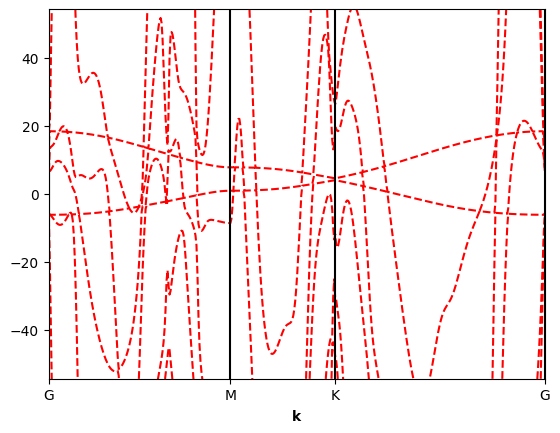

In [105]:
special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, -0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

fig, ax = plt.subplots()

# ifr = 0
# kpath = dataset.structures[ifr].cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
# plot_bands_frame_(dataset.structures[ifr], list(dataset.fock_realspace[ifr].values()), list(dataset.overlap_realspace[ifr].values()),
#                   dataset.cells[ifr], dataset.kmesh[ifr],
#                   special_symm = 'hexagonal', kpath = kpath, ax = ax, color = 'blue')

ifr = 1
kpath = dataset.structures[ifr].cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
_ =plot_bands_frame_(dataset.structures[ifr], list(dataset.fock_realspace[ifr].values()), list(dataset.overlap_realspace[ifr].values()),
                  dataset.cells[ifr], dataset.kmesh[ifr],
                  special_symm = 'hexagonal', kpath = kpath, ax = ax, color = 'red', ls = '--')

# Targets

In [6]:
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 

def get_targets(dataset, device ="cpu", cutoff = None, target='fock'):
    if target.lower() == 'fock':
        matrices_negative = dataset._fock_realspace_negative_translations
    elif target.lower() == 'overlap':
        matrices_negative = dataset._overlap_realspace_negative_translations
    else: 
        raise ValueError('target must be fock or overlap')
    blocks = matrix_to_blocks(dataset, matrices_negative , device = 'cpu', cutoff = cutoff, all_pairs = True, target= target)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks

In [7]:
cutoff = 6
# target_blocks_c, target_coupled_blocks_c = get_targets(dataset, cutoff = cutoff)
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff)


# Features

In [8]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH

hypers_pair = {'cutoff': cutoff,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, 
                      both_centers = both_centers, mic = False,
                      kmesh = dataset.kmesh, device="cpu", lcut = LCUT, return_rho0ij = return_rho0ij, 
                      counter = dataset._translation_counter, 
                      T_dict = dataset._translation_dict)

if both_centers and not return_rho0ij:
    NU = 3
else:
    NU = 2
rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = 'cpu',
                                feature_names = rhoij.property_names)

hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = True)

{'cutoff': 6, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.3, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}
torch.Size([1916, 1, 10]) 1
torch.Size([3792, 1, 10]) 2
torch.Size([1916, 3, 10]) 1
torch.Size([3792, 3, 10]) 2
torch.Size([1916, 5, 10]) 1
torch.Size([3792, 5, 10]) 2
torch.Size([1916, 7, 10]) 1
torch.Size([3792, 7, 10]) 2
torch.Size([1916, 9, 10]) 1
torch.Size([3792, 9, 10]) 2


# Train

In [9]:
from mlelec.metrics import L2_kspace_loss

In [10]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [11]:
model = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model = model.double()

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-4, history_size=10, 
#                     max_iter=4, 
#                     line_search_fn="strong_wolfe")

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=50, verbose=True
)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)# last_epoch=-1,

In [ ]:
losses =[]
for epoch in range(18000):
    
    model.train(True)
    # def closure():
    #     optimizer.zero_grad()
    #     pred = model.forward()
    #     loss = L2_loss(pred, target_train)
    #     # loss = torch.linalg.norm(rmat - matrices)**2
    #     loss.backward()
    #     return loss

    # optimizer.step(closure)
    # train_loss = closure().item()
    #ADAM 
    optimizer.zero_grad()
    pred = model()
    # target.append(data['output'])
    # train_pred.append(pred)
    loss = L2_kspace_loss(pred, target_coupled_blocks, dataset)
    train_loss = loss.item()
    loss.backward()
    optimizer.step()
    
    # train_loss = loss_fn(torch.cat(train_pred), torch.cat(target))
    # print(train_loss - epoch_loss)
    losses.append(train_loss)
    scheduler.step(loss)
    

        # val_loss = loss_fn(torch.cat(val_pred), torch.cat(val))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, train loss on all blocks {train_loss}")
        # validate 
        # valpred = model.predict(hfeat_test, target_test)
        # val_loss  = L2_kspace_loss(valpred, target_test)
        
        # print(f"Epoch {epoch} val loss {val_loss}")

Epoch 0, train loss on all blocks 389392.9972835954
Epoch 10, train loss on all blocks 249476.52620173513


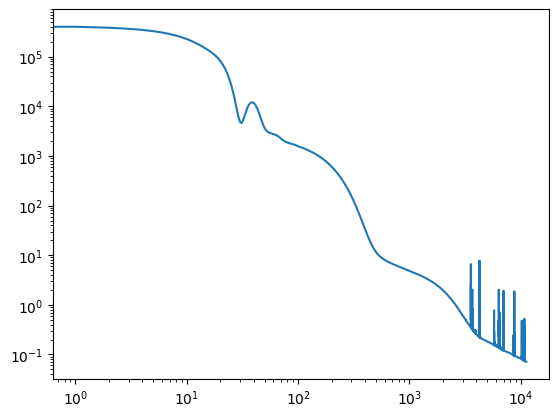

In [32]:
plt.loglog(losses)

In [33]:
pred = model.forward()

In [41]:
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.plot_utils import plot_bands_frame

In [97]:
pred_matrix = blocks_to_matrix(pred, dataset)

In [107]:
H_K = dataset.compute_matrices_kspace(pred_matrix)

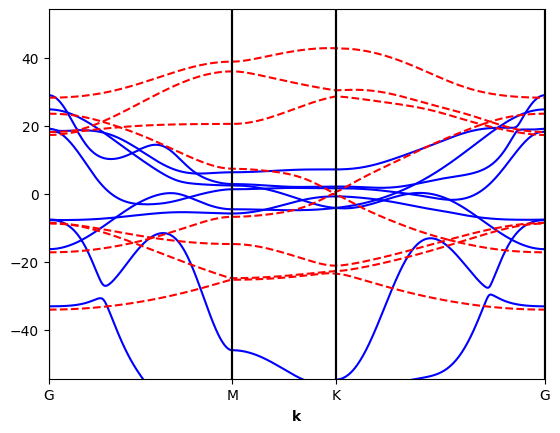

In [105]:
special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

fig, ax = plt.subplots()

ifr = 7
kpath = dataset.structures[ifr].cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
plot_bands_frame(dataset, ifr, pred_matrix[ifr], dataset.overlap_realspace[ifr], 
                  special_symm = 'hexagonal', kpath = kpath, ax = ax, color = 'blue');
plot_bands_frame(dataset, ifr,dataset.fock_realspace[ifr], dataset.overlap_realspace[ifr],
                  special_symm = 'hexagonal', kpath = kpath, ax = ax, color = 'red', ls='--');

# ifr = 1
# kpath = dataset.structures[ifr].cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
# _ =plot_bands_frame_(dataset.structures[ifr], torch.stack(list(pred_matrix[ifr].values())).detach().numpy(), list(dataset.overlap_realspace[ifr].values()),
#                   dataset.cells[ifr], dataset.kmesh[ifr],
#                   special_symm = 'hexagonal', kpath = kpath, ax = ax, color = 'red', ls = '--')

In [101]:
pred_matrix

[{(0,
   0,
   0): tensor([[-5.2929e+01, -1.6556e+01,  1.5084e-03,  3.5115e-03,  3.2289e-03,
            7.4573e+00, -1.6031e+00,  1.7773e+00, -7.6370e-02,  1.5217e-02],
          [-1.5079e+01, -1.0422e+01,  2.1045e-02,  1.0065e-01,  9.6856e-02,
           -1.3840e+00, -3.0317e+00,  1.4798e+00, -6.4087e-02,  2.0533e-02],
          [ 1.7455e-03,  2.0892e-02, -8.3629e-01, -9.4223e-04, -8.4434e-02,
           -1.7757e+00, -1.5406e+00,  8.2935e-01, -1.6709e-02,  7.0275e-03],
          [ 4.0848e-03,  9.8864e-02, -9.4199e-04, -7.4689e-01, -3.0439e-03,
            7.5795e-02,  6.3952e-02, -1.6569e-02, -9.0404e-01,  1.2265e-04],
          [ 3.7617e-03,  9.5082e-02, -8.4440e-02, -3.0440e-03, -9.8375e-01,
           -1.4890e-02, -2.2741e-02,  7.1294e-03,  1.1836e-04, -1.4443e-01],
          [ 7.4573e+00, -1.6031e+00, -1.7773e+00,  7.6370e-02, -1.5217e-02,
           -5.2929e+01, -1.6556e+01, -1.5084e-03, -3.5115e-03, -3.2289e-03],
          [-1.3840e+00, -3.0317e+00, -1.4798e+00,  6.4087e-02, -2

In [108]:
for ifr in range(len(H_K)):
    for ik in range(len(H_K[ifr])):
        
        print(ifr, ik, torch.norm(H_K[ifr][ik]).item(), torch.norm(dataset.fock_kspace[ifr][ik]).item())

0 0 18.043838476777697 18.046847089078753
0 1 15.202461887030776 17.99408524331029
0 2 11.53313232850838 17.831850112497126
0 3 10.725850417063345 17.61797037894219
0 4 11.200574919294041 17.513544224932346
0 5 10.725850417063349 17.617970378942125
0 6 11.533132328508376 17.831850112497154
0 7 15.202461887030767 17.994085243310366
0 8 15.159793845235187 18.001818845327684
0 9 12.041501229871125 17.895954386476586
0 10 9.96784858139157 17.696259282073807
0 11 10.025112553335068 17.518288583696155
0 12 10.028658633232387 17.51304893224927
0 13 9.96822430485592 17.683750141202346
0 14 12.045416732599552 17.88369689558059
0 15 15.170471568530832 17.99682264171969
0 16 11.410157691682809 17.860162983362322
0 17 9.907002055046439 17.717231601355966
0 18 8.829321350985099 17.535753282334838
0 19 8.695480923853987 17.443755226026394
0 20 8.84885927428176 17.517946102418108
0 21 9.955347702615304 17.69232216236287
0 22 11.457526738422203 17.842792024251533
0 23 11.956293941206944 17.90319479014

In [58]:
H_K[0][0]-H_K[0][8]

tensor([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
       grad_fn=<SubBackward0>)

In [62]:
pred_matrix[0][0,0,0,]-pred_matrix[0][0,1,0]

tensor([[-4.9655e+01, -1.5800e+01,  2.8414e-01,  3.4175e-03, -1.5219e-01,
          7.5184e+00, -1.3031e+00,  1.4516e+00, -6.5371e-02, -4.2826e-03],
        [-1.4175e+01, -9.5363e+00,  1.2290e-01,  9.8361e-02,  1.0433e-01,
         -1.0611e+00, -2.2737e+00,  1.2599e+00, -5.4890e-02, -2.6059e-02],
        [-2.7479e-01, -2.3499e-02, -8.5175e-01, -1.1586e-03, -5.3415e-02,
         -1.4513e+00, -1.3214e+00,  5.4564e-01, -1.1200e-02,  8.1945e-02],
        [ 3.9514e-03,  9.6387e-02, -8.8190e-04, -6.1202e-01, -3.0895e-03,
          6.4640e-02,  5.4785e-02, -1.1032e-02, -5.7695e-01, -1.5814e-03],
        [ 1.5890e-01,  1.8366e-01, -5.2665e-02, -2.9287e-03, -9.7114e-01,
          1.0101e-02,  1.9406e-02,  8.0586e-02, -1.5667e-03, -9.8997e-02],
        [ 4.2192e-02, -3.1818e-02, -2.6309e+00, -1.8060e-05,  1.5104e+00,
         -4.9655e+01, -1.5800e+01,  2.7898e-01, -3.3836e-03, -1.6236e-01],
        [-2.3774e-02, -4.4160e-02, -2.1870e+00, -8.2881e-05,  1.2642e+00,
         -1.4175e+01, -9.5361e+0

In [38]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges, kernels = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [ ]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True)
print(loss_ridge_bias)

(1e-12, 10000.0)

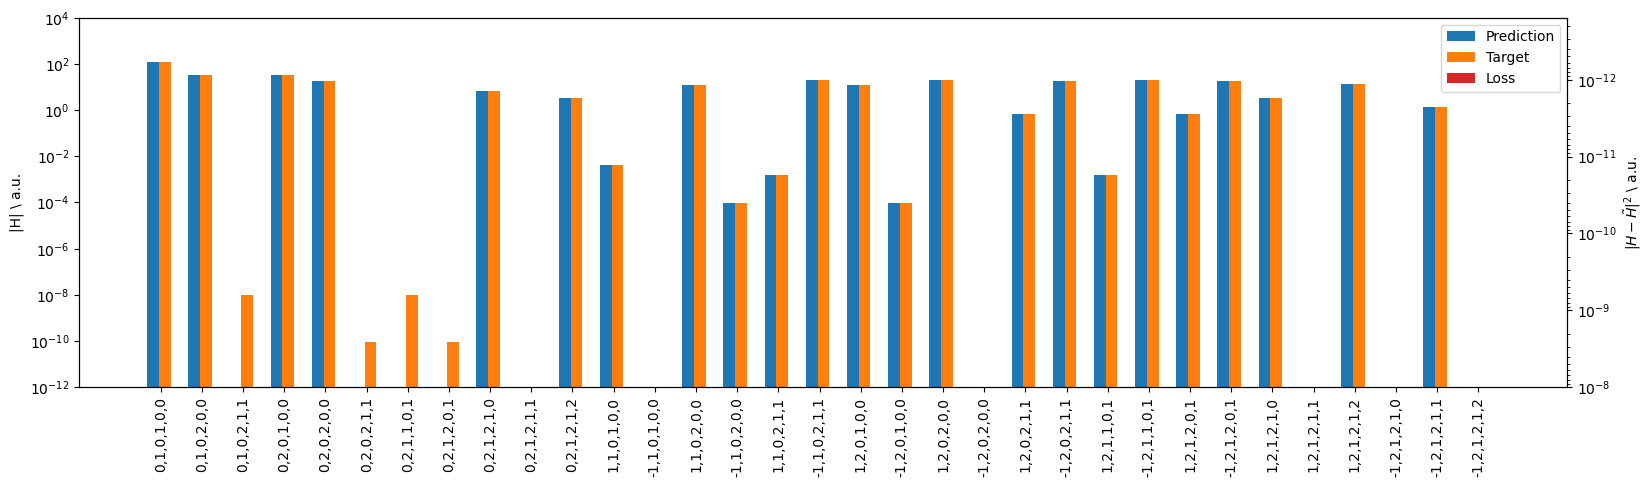

In [258]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-8,)
ax.set_ylim(1e-12,1e4)

## C2 174

In [74]:
workdir = '/home/nigam/scratch/MAC/k-hamiltonian/'
root = f'{workdir}/examples/data/periodic/c2/'
ORBS = 'sto-3g'
START = 0
STOP = 20
frames = read(f'{root}/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = True

kmesh = [8,8,1]
kfock = [np.load(f"{root}/results_C2_174_881/fock_{i}_881.npy") for i in range(START, STOP)]
kover = [np.load(f"{root}/results_C2_174_881/over_{i}_881.npy") for i in range(START, STOP)]
for ifr in range(len(frames)):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
        kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = kfock, overlap_kspace = kover, device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

In [75]:
cutoff = 6
target_blocks_nc, target_coupled_blocks_nc = get_targets(dataset, cutoff = None)
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff)

target_blocks_nc_over, target_coupled_blocks_nc_over = get_targets(dataset, cutoff = None, target='overlap')
target_blocks_over, target_coupled_blocks_over = get_targets(dataset, cutoff = cutoff, target='overlap')
